## 1. Import Libraries

In [0]:
%%capture
#Install skorch package 
!pip install lime

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Vizualization 
from matplotlib import pyplot as plt

#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#Utilities
import os

## 2. Download Preprocessed Data

In [0]:
%%capture
#Get data
if not os.path.isfile('train_data.csv'):
    !wget 'https://drive.google.com/uc?export=download&id=1ESF8oUoZMHOM5VXte4vlhM1_-p_Yxa2k' -O train_data.csv
if not os.path.isfile('test_data.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1VjghtXl1OuZy4MGf995Zq34YSOP3Rf8p' -O test_data.csv

##3. Parse Data 

In [0]:
train_data = pd.read_csv('train_data.csv')
train_data = train_data.drop(train_data.columns[0], axis=1) #Drop original index
y_train = train_data['label']
X_train = train_data.drop('label', axis = 1) 

no_features = X_train.shape[1]

print(y_train.value_counts())
X_train.head()

0.0    2582
1.0      31
Name: label, dtype: int64


,dcar_posA_2_Err,slopedZAchi2Pos,MIPattachSlopeC,meanMultNeg,mediumPtAPos,dcarCP0,dcaz_negA_1_Err,tpcConstrainPhiA,dcar_negA_chi2,offsetdZC,dcaz_negA_0_Err,zPullHighPt,vertOK,tpcItsMatchHighPtA,deltaPt,resolutionMIP,entriesVertY,entriesMult,dcaz_posA_0,dcar_posC_1,slopedRAchi2Pos,tpcConstrainPhiC,iroc_A_side,meanVertZ,slopedZAchi2,deltaPtC,offsetdZAErr,offsetdZA,dcaz_posA_2_Err,dcaz_negC_0_Err,offsetdRA,meanMIPele,offsetdZAchi2Pos,medianHVandPTGainCorrIROC,iroc_C_side,vertAll,dcar_negA_1_Err,offsetdRAchi2Pos,meanMult,qOverPtC,...,phiPull,rmsTPCChi2,dcar_negC_1_Err,offsetdRCchi2,meanTPCChi2,rmsVertY,tpcItsMatchHighPtC,dcaz_negC_2_Err,yPullHighPt,tpcItsMatchC,deltaPtchi2C,deltaPtchi2,rmsMultNeg,meanTPCnclF,ptPullHighPt,oroc_C_side,slopedZCchi2Pos,rmsTPCncl,dcar_posC_2_Err,offsetdZCchi2Pos,deltaPtchi2A,resolutionMIPele,dcarCP1,dcar_posA_1_Err,slopedRCchi2Pos,slopeCTPCnclFErr,slopeCTPCnclF,dcar_negC_0_Err,slopedZC,lambdaPull,dcaz_posC_1_Err,offsetdRCchi2Neg,dcaz_negC_chi2,offsetdRCchi2Pos,dcaz_posC_0_Err,oroc_A_side,offsetdZAchi2,dcar_negA_0_Err,dcar_negC_chi2,slopeATPCnclF
0,0.099409,0.014310,0.801887,0.222395,0.287348,0.015659,0.090696,0.250600,0.023914,0.681802,0.093288,0.536037,0.048471,0.484353,0.830216,0.084010,0.048471,0.048471,0.286951,0.716267,0.023016,0.343302,1.0,0.470134,0.007945,0.639889,0.043615,0.615646,0.100054,0.084979,0.748467,0.538374,0.014310,0.634857,1.0,0.048232,0.100657,0.023016,0.236333,0.999787,...,0.261710,0.396997,0.108241,0.180049,0.408427,0.334197,0.513542,0.087115,0.411626,0.486461,0.185221,0.251164,0.269275,0.628099,0.500062,1.0,0.083777,0.188709,0.076326,0.083777,0.560022,0.376559,0.865777,0.108347,0.158491,0.615037,0.615037,0.111798,0.671210,0.544371,0.082443,0.226467,0.036121,0.158491,0.079352,1.0,0.007945,0.109410,0.046268,0.336805
1,0.099385,0.033617,0.808663,0.223777,0.275670,0.014604,0.090423,0.252088,0.042604,0.631552,0.092961,0.596938,0.048533,0.507080,0.726710,0.075907,0.048533,0.048533,0.276645,0.716802,0.037232,0.347691,1.0,0.544646,0.061303,0.589440,0.043206,0.607734,0.099591,0.084341,0.740841,0.539351,0.033617,0.577720,1.0,0.048154,0.099989,0.037232,0.237175,0.999787,...,0.282124,0.365360,0.107216,0.179455,0.392618,0.271104,0.504607,0.086553,0.435778,0.496519,0.235751,0.303607,0.276336,0.641418,0.516194,1.0,0.042756,0.179429,0.075625,0.042756,0.404344,0.376618,0.865010,0.107485,0.167685,0.642677,0.642677,0.111131,0.608461,0.531888,0.082237,0.211377,0.057000,0.167685,0.079100,1.0,0.061303,0.108680,0.042741,0.349069
2,0.100365,0.011109,0.782080,0.229582,0.295865,0.021435,0.091606,0.265814,0.031262,0.770265,0.094130,0.486393,0.047455,0.456619,0.808216,0.078561,0.047455,0.047455,0.289770,0.735507,0.025562,0.331459,1.0,0.451859,0.032410,0.614573,0.046143,0.590165,0.100842,0.086018,0.728972,0.539136,0.011109,0.812007,1.0,0.047118,0.101562,0.025562,0.241398,0.999447,...,0.327544,0.387593,0.109372,0.258543,0.355660,0.250432,0.484668,0.088182,0.422740,0.467657,0.396498,0.182232,0.274872,0.640624,0.510723,1.0,0.076322,0.186384,0.077114,0.076322,0.110420,0.376617,0.865149,0.109269,0.235758,0.671191,0.671191,0.112729,0.729725,0.552267,0.083694,0.294714,0.082043,0.235758,0.080546,1.0,0.032410,0.109990,0.049643,0.279933
3,0.082242,0.145376,0.819095,0.163176,0.273245,0.010944,0.070409,0.329643,0.047953,0.645637,0.072335,0.447257,0.077830,0.586474,0.765543,0.083906,0.077830,0.077830,0.389638,0.826607,0.009831,0.113821,1.0,0.108901,0.126710,0.611797,0.026511,0.662682,0.077734,0.061588,0.813271,0.539873,0.145376,0.961979,1.0,0.077466,0.079752,0.009831,0.161657,0.999787,...,0.301325,0.245516,0.086518,0.128020,0.487033,0.164043,0.559118,0.063077,0.420083,0.599240,0.349633,0.074164,0.215323,0.709143,0.532278,1.0,0.103218,0.119813,0.059253,0.103218,0.148112,0.377079,0.862610,0.089063,0.128641,0.590844,0.590844,0.089462,0.590003,0.523875,0.060386,0.140410,0.066480,0.128641,0.058024,1.0,0.126710,0.086670,0.074572,0.535948
4,0.095194,0.011447,0.817958,0.229661,0.328411,0.018384,0.087526,0.259542,0.042342,0.7128

In [0]:
test_data = pd.read_csv('test_data.csv')
test_data = test_data.drop(test_data.columns[0], axis=1) #Drop original index
y_test = test_data['label']
X_test = test_data.drop('label', axis = 1) 
print(y_test.value_counts())
X_test.head()

0.0    653
1.0     33
Name: label, dtype: int64


,dcar_posA_2_Err,slopedZAchi2Pos,MIPattachSlopeC,meanMultNeg,mediumPtAPos,dcarCP0,dcaz_negA_1_Err,tpcConstrainPhiA,dcar_negA_chi2,offsetdZC,dcaz_negA_0_Err,zPullHighPt,vertOK,tpcItsMatchHighPtA,deltaPt,resolutionMIP,entriesVertY,entriesMult,dcaz_posA_0,dcar_posC_1,slopedRAchi2Pos,tpcConstrainPhiC,iroc_A_side,meanVertZ,slopedZAchi2,deltaPtC,offsetdZAErr,offsetdZA,dcaz_posA_2_Err,dcaz_negC_0_Err,offsetdRA,meanMIPele,offsetdZAchi2Pos,medianHVandPTGainCorrIROC,iroc_C_side,vertAll,dcar_negA_1_Err,offsetdRAchi2Pos,meanMult,qOverPtC,...,phiPull,rmsTPCChi2,dcar_negC_1_Err,offsetdRCchi2,meanTPCChi2,rmsVertY,tpcItsMatchHighPtC,dcaz_negC_2_Err,yPullHighPt,tpcItsMatchC,deltaPtchi2C,deltaPtchi2,rmsMultNeg,meanTPCnclF,ptPullHighPt,oroc_C_side,slopedZCchi2Pos,rmsTPCncl,dcar_posC_2_Err,offsetdZCchi2Pos,deltaPtchi2A,resolutionMIPele,dcarCP1,dcar_posA_1_Err,slopedRCchi2Pos,slopeCTPCnclFErr,slopeCTPCnclF,dcar_negC_0_Err,slopedZC,lambdaPull,dcaz_posC_1_Err,offsetdRCchi2Neg,dcaz_negC_chi2,offsetdRCchi2Pos,dcaz_posC_0_Err,oroc_A_side,offsetdZAchi2,dcar_negA_0_Err,dcar_negC_chi2,slopeATPCnclF
0,0.098799,0.046217,0.803350,0.234782,0.306302,0.018078,0.091163,0.303375,0.034440,0.660074,0.093753,0.521944,0.047900,0.475199,0.803058,0.082818,0.047900,0.047900,0.308343,0.715060,0.020971,0.344849,1.0,0.423070,0.036162,0.634080,0.046554,0.620963,0.100692,0.084661,0.759383,0.538482,0.046217,0.667713,1.0,0.047674,0.100659,0.020971,0.248824,0.999787,...,0.261294,0.384600,0.107509,0.177556,0.410367,0.329697,0.495564,0.086880,0.419484,0.474454,0.125692,0.276319,0.295220,0.627010,0.489901,1.0,0.056506,0.180089,0.076083,0.056506,0.572732,0.375950,0.865450,0.107209,0.157749,0.662916,0.662916,0.110958,0.633833,0.542400,0.082234,0.218609,0.073844,0.157749,0.079037,1.0,0.036162,0.109088,0.045819,0.344470
1,0.096841,0.049972,0.795997,0.222481,0.268590,0.014356,0.088502,0.269188,0.050615,0.675663,0.090905,0.547555,0.050425,0.505892,0.810589,0.069549,0.050425,0.050424,0.321185,0.716728,0.022740,0.330639,1.0,0.338586,0.075439,0.644876,0.041766,0.623730,0.097658,0.082116,0.739433,0.538652,0.049972,0.495576,1.0,0.050114,0.098124,0.022740,0.234863,0.999787,...,0.285271,0.367797,0.106112,0.171637,0.332681,0.297401,0.526761,0.084041,0.415989,0.500646,0.371934,0.228631,0.284583,0.655380,0.503716,1.0,0.062795,0.175384,0.074503,0.062795,0.101715,0.375809,0.864958,0.105382,0.173739,0.683243,0.683243,0.108949,0.639007,0.629082,0.080117,0.154749,0.042763,0.173739,0.077198,1.0,0.075439,0.106463,0.047708,0.299740
2,0.105751,0.009535,0.838848,0.989753,0.302174,0.050498,0.103703,0.315488,0.051759,0.613389,0.106710,0.430163,0.024558,0.237037,0.726154,0.204130,0.024558,0.024543,0.389459,0.899135,0.006403,0.126458,1.0,0.082509,0.003734,0.587205,0.139021,0.628398,0.112457,0.100001,0.851906,0.539130,0.009535,0.826088,1.0,0.023706,0.099933,0.006403,0.989108,0.499893,...,0.220911,0.825788,0.110855,0.248369,0.968898,0.195699,0.300754,0.102748,0.425733,0.188218,0.337375,0.297998,0.974377,0.021173,0.679299,0.0,0.019024,0.246163,0.085141,0.019024,0.213520,0.383265,0.883049,0.113986,0.255992,0.024412,0.024412,0.114457,0.568235,0.949644,0.095523,0.213982,0.067394,0.255992,0.092261,1.0,0.003734,0.108997,0.119361,0.963921
3,0.080283,0.143404,0.816649,0.151936,0.269656,0.016069,0.069010,0.309577,0.033644,0.653260,0.071045,0.483119,0.080783,0.581033,0.753561,0.083028,0.080783,0.080782,0.366834,0.817577,0.023722,0.092733,1.0,0.343812,0.123573,0.603342,0.026335,0.648771,0.076672,0.062715,0.797275,0.540337,0.143404,0.920796,0.0,0.080538,0.078097,0.023722,0.150054,0.999787,...,0.299547,0.354456,0.085296,0.237796,0.474781,0.157524,0.591752,0.066231,0.430702,0.593187,0.312344,0.291174,0.186329,0.607272,0.499107,0.0,0.349859,0.248537,0.063462,0.349859,0.216018,0.377561,0.866352,0.087376,0.246554,0.571697,0.571697,0.090432,0.633189,0.513145,0.059144,0.212509,0.317644,0.246554,0.058863,1.0,0.123573,0.084869,0.125151,0.485031
4,0.097636,0.041938,0.811427,0.243890,0.282890,0.015964,0.089743,0.310164,0.037153,0.6295

## 4. Fit Random Forest to Train Data and make prediction

In [0]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
pred = clf.predict(X_test)

acc = accuracy_score(pred, y_test)
b_acc = balanced_accuracy_score(pred, y_test)

print('Accuracy score: {:.2f}%'.format(acc*100))
print('Balanced accuracy score: {:.2f}%'.format(b_acc*100))

Accuracy score: 98.10%
Balanced accuracy score: 89.25%


## 5. Explain Outliers with LIME

In [0]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.to_numpy(),feature_names=X_train.columns.tolist(),
                                 class_names=['Normal', 'Outlier'], discretize_continuous=True)

outliers_ids = y_test[y_test == 1].index
inliners_ids = y_test[y_test == 0].index

In [0]:
#Get Explenations
exp_outliers = []
exp_inliners = []
for i in range(3):
    exp_o = explainer.explain_instance(X_test.to_numpy()[outliers_ids[i]], clf.predict_proba, num_features=15)
    exp_i = explainer.explain_instance(X_test.to_numpy()[inliners_ids[i]], clf.predict_proba, num_features=15)

    exp_outliers.append(exp_o)
    exp_inliners.append(exp_i)

## 6. Visualize Explenations - example inliner

In [0]:
#Wisualize explenations for inliner
exp_inliners[0].as_list()

[('resolutionMIP > 0.08', 0.006650910788779718),
 ('dcar_posC_1_Err > 0.08', -0.005089047783376775),
 ('dcaz_negA_1_Err > 0.09', 0.005070909458964273),
 ('meanMultPos > 0.25', 0.004654491808853057),
 ('dcar_posA_2_Err > 0.10', -0.004365590518071761),
 ('0.66 < offsetdZCNeg <= 0.68', -0.0037092216597752366),
 ('dcar_posC_0_Err > 0.08', -0.0036682906826326534),
 ('0.57 < slopedZCNeg <= 0.59', -0.003464223824264854),
 ('meanMultNeg > 0.23', 0.0030966293321710325),
 ('offsetdZAErr > 0.04', 0.003055902886973551),
 ('offsetdZA <= 0.62', 0.0030027767780082533),
 ('dcar_negC_2_Err > 0.11', -0.0027630003863310004),
 ('0.18 < rmsTPCncl <= 0.18', -0.0026709835351140226),
 ('dcar_posC_2_Err > 0.07', -0.002628529924251435),
 ('0.64 < slopeCTPCnclFErr <= 0.67', -0.0025077629007371274)]

[('resolutionMIP > 0.08', 0.006650910788779718), ('dcar_posC_1_Err > 0.08', -0.005089047783376775), ('dcaz_negA_1_Err > 0.09', 0.005070909458964273), ('meanMultPos > 0.25', 0.004654491808853057), ('dcar_posA_2_Err > 0.10', -0.004365590518071761), ('0.66 < offsetdZCNeg <= 0.68', -0.0037092216597752366), ('dcar_posC_0_Err > 0.08', -0.0036682906826326534), ('0.57 < slopedZCNeg <= 0.59', -0.003464223824264854), ('meanMultNeg > 0.23', 0.0030966293321710325), ('offsetdZAErr > 0.04', 0.003055902886973551), ('offsetdZA <= 0.62', 0.0030027767780082533), ('dcar_negC_2_Err > 0.11', -0.0027630003863310004), ('0.18 < rmsTPCncl <= 0.18', -0.0026709835351140226), ('dcar_posC_2_Err > 0.07', -0.002628529924251435), ('0.64 < slopeCTPCnclFErr <= 0.67', -0.0025077629007371274)]


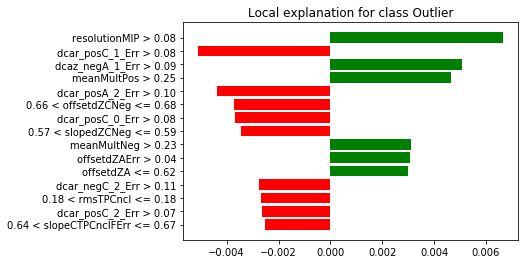

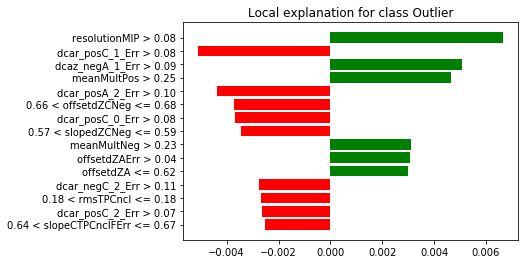

In [0]:
exp_inliners[0].as_pyplot_figure() #No idea why graphs are doubled

## 7. Visualize Explenations - example outliers

In [0]:
exp_outliers[0].as_list()

[('offsetdZC <= 0.66', 0.007217145264270775),
 ('resolutionMIP > 0.08', 0.006951671727652393),
 ('offsetdZAchi2Pos <= 0.03', 0.006442877493168277),
 ('slopedZCNeg <= 0.53', 0.006110626751529065),
 ('rmsTPCncl > 0.18', 0.006061026906230476),
 ('meanMultPos > 0.25', 0.005460303831260258),
 ('offsetdZCNeg <= 0.66', 0.005320680608042231),
 ('dcar_posC_1_Err > 0.08', -0.004540045262829322),
 ('dcaz_negA_1_Err > 0.09', 0.0043645346417002994),
 ('slopeCTPCnclFErr <= 0.57', 0.003836765220012074),
 ('meanVertZ <= 0.24', 0.003744357340469067),
 ('dcar_posA_2_Err > 0.10', -0.003493356339581909),
 ('meanMultNeg > 0.23', 0.0031272604455830797),
 ('yPull <= 0.08', 0.002902940334946063),
 ('slopedZAchi2 <= 0.04', 0.00268760275547935)]

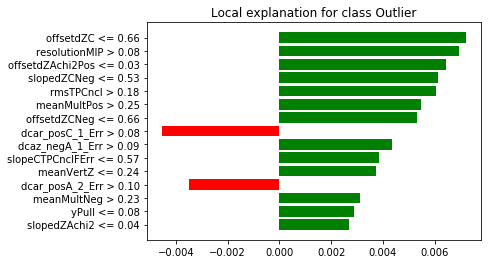

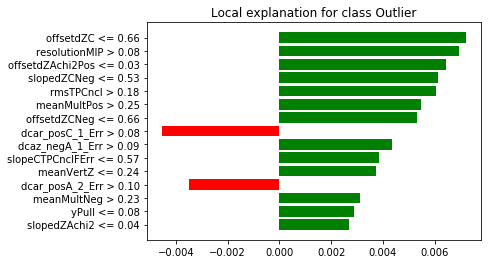

In [0]:
exp_outliers[0].as_pyplot_figure()

In [0]:
exp_outliers[1].as_list()

[('dcar_posC_1_Err <= 0.06', 0.01742641078159949),
 ('dcar_posA_2_Err <= 0.08', 0.011601679353133785),
 ('dcar_negC_2_Err <= 0.10', 0.00971216626223338),
 ('dcar_posC_0_Err <= 0.06', 0.009560681816682706),
 ('dcar_posC_2_Err <= 0.06', 0.007237084839298069),
 ('rmsTPCncl > 0.18', 0.006523823126033016),
 ('meanTPCnclF > 0.67', 0.006025951714769337),
 ('offsetdZCchi2Pos > 0.12', 0.005013549393312157),
 ('dcarCP1 <= 0.86', 0.004883771119368391),
 ('meanVertX > 0.76', 0.004626570884584797),
 ('rmsVertY > 0.48', 0.004202853449824295),
 ('meanTPCChi2 <= 0.35', 0.00374733166287818),
 ('yPull <= 0.08', 0.003450105959387992),
 ('meanVertY > 0.31', 0.0031323979409920775),
 ('phiPullHighPt > 0.59', 0.0030557948240206353)]

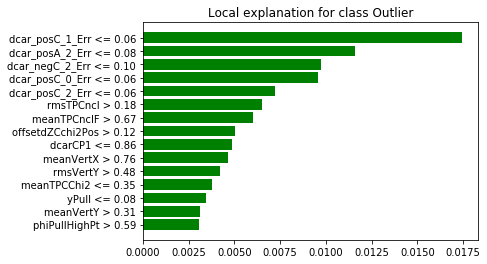

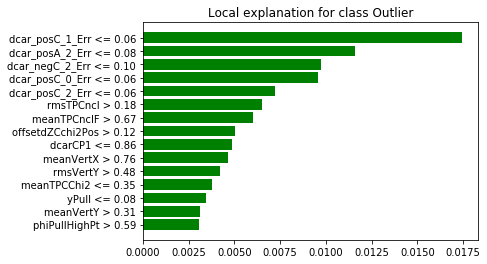

In [0]:
exp_outliers[1].as_pyplot_figure()

In [0]:
exp_outliers[2].as_list()

[('offsetdZAchi2Pos <= 0.03', 0.008019206769012254),
 ('offsetdZC <= 0.66', 0.007281045184545193),
 ('dcaz_negA_1_Err > 0.09', 0.006524791733040854),
 ('dcar_posC_1_Err > 0.08', -0.005474832883432134),
 ('meanMultPos > 0.25', 0.004605624146604965),
 ('offsetdZAErr > 0.04', 0.004459598034987625),
 ('meanMultNeg > 0.23', 0.00434579023122066),
 ('dcarCP1 <= 0.86', 0.004213909742145196),
 ('resolutionMIPele <= 0.38', 0.003557910422132617),
 ('rmsMultPos > 0.32', 0.0033329563298567333),
 ('tpcConstrainPhiC > 0.35', 0.0032778396877041634),
 ('dcaz_posC_chi2 <= 0.04', 0.0027765164908200206),
 ('dcar_negC_chi2 <= 0.05', 0.0026686921291897985),
 ('dcaz_posC_0_Err > 0.08', 0.0025395082601211024),
 ('meanMult > 0.24', 0.002412795274788291)]

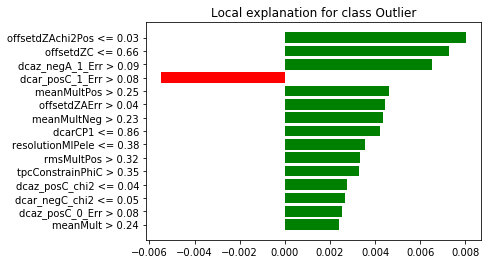

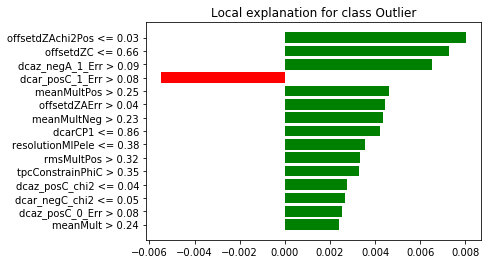

In [0]:
exp_outliers[2].as_pyplot_figure()